# Sentiment analyses on game reviews using deep learning

Lately I discovered the youtube channel of [*Siraj Raval*](https://www.youtube.com/channel/UCWN3xxRkmTPmbKwht9FuE5A) that I can highly recommend for everyone who wants to learn about artificial intelligence meanwhile being highly entertained. In his videos he regularly creates challanges for his audiance to solve. In his latest video that was about making sentiment analysis on an IMDB movie reviews dataset he challanged us to do something simmilar on game reviews. The dataset is open and avaialble at [Kaggle](https://www.kaggle.com/egrinstein/20-years-of-games/).

I found it an interesting challange where I can also apply some of my new skills that I just learned on [Practical Deep Learning For Coders MOOC](http://course.fast.ai/) that I also highly recommend for everyone interested in deep learning.

Let's see my results!

## Data preparation

I start with importing all the libraries I will use. Most importantly:
    1. Pandas: reading, storing and manipulating my data
    2. Keras: do deep learning (I will use Theano backend but I guess it works similarly with Tensorflow)
    3. numpy: matrix operations
    4. pickle: saving results (not the model, keras has it's own functions for that)

If you want to reproduce my notebook please note that I use Python 3.5 (i.e. urllib works little differently in Python 2)

In [211]:
%matplotlib inline
import pandas as pd
import keras
import urllib
import re
import pickle
import matplotlib.pyplot as plt
from itertools import chain
from collections import Counter
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

I already downloaded the database (that is a single csv file). I just read it into a pandas DataFrame.

In [2]:
reviews=pd.read_csv("ign.csv").drop("Unnamed: 0", axis=1)
reviews.head()

,score_phrase,title,url,platform,score,genre,editors_choice,release_year,release_month,release_day
0,Amazing,LittleBigPlanet PS Vita,/games/littlebigplanet-vita/vita-98907,PlayStation Vita,9.0,Platformer,Y,2012,9,12
1,Amazing,LittleBigPlanet PS Vita -- Marvel Super Hero E...,/games/littlebigplanet-ps-vita-marvel-super-he...,PlayStation Vita,9.0,Platformer,Y,2012,9,12
2,Great,Splice: Tree of Life,/games/splice/ipad-141070,iPad,8.5,Puzzle,N,2012,9,12
3,Great,NHL 13,/games/nhl-13/xbox-360-128182,Xbox 360,8.5,Sports,N,2012,9,11
4,Great,NHL 13,/games/nhl-13/ps3-128181,PlayStation 3,8.5,Sports,N,2012,9,11


Our task is to predict the 	*score_phrase* of the reviews but we also have numerical scores. Let's check the distribution of score_phrases:

In [3]:
reviews.groupby("score_phrase").count().title

score_phrase
Amazing        1804
Awful           664
Bad            1269
Disaster          3
Good           4741
Great          4773
Masterpiece      55
Mediocre       1959
Okay           2945
Painful         340
Unbearable       72
Name: title, dtype: int64

We can see that the categories are not really balanced and some category contains just really few elements (i.e. Disaster only 3). The phrases probably follow some ordinality so may we can use just the score to infer the phrases. We can check if our assumption is right by checking the mean scoe belonging to each phrases: 

In [4]:
reviews.groupby('score_phrase')['score'].mean().sort_values()

score_phrase
Disaster        0.666667
Unbearable      1.290278
Painful         2.267941
Awful           3.290211
Bad             4.331600
Mediocre        5.318530
Okay            6.366553
Good            7.369099
Great           8.316510
Amazing         9.176663
Masterpiece    10.000000
Name: score, dtype: float64

The order is quite visible. So my plan is to predict the score of a review and connect it to the category with the closest value. I create a simple function for that.

In [5]:
mean_scores=reviews.groupby('score_phrase')['score'].mean().sort_values()
score_list=mean_scores.tolist()
phrase_score_dict=mean_scores.to_dict()
score_phrase_dict= {v:k for k,v in phrase_score_dict.items()}

def phrase_to_score(score,score_list=score_list):
    return score_phrase_dict[min(score_list, key=lambda x:abs(x-score))]

I clean and tokenize the titles

In [6]:
regex = re.compile('[^a-zA-Z0-9]')
reviews["title_2"]=reviews["title"].apply(lambda x: regex.sub(' ', x).lower().strip().split())

Check the distribution of the number of words in the titles and the total number of different words used:

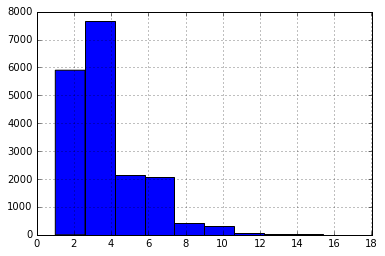

In [7]:
reviews.head()
reviews["title_2"].apply(len).hist()

In [8]:
words=set(list(chain.from_iterable(reviews["title_2"].tolist())))
number_of_words=len(words)
print("Different number of words used: {} ".format(number_of_words))

Different number of words used: 7938 


Making dictionaries to translate beetween words and word ids:

In [9]:
word_frequency_dict=Counter(list(chain.from_iterable(reviews["title_2"].tolist())))
word_idx_dict={word: idx for idx, word in enumerate(sorted(word_frequency_dict, key=lambda x: -word_frequency_dict[x]))}
idx_word_dict={idx: word for idx, word in enumerate(sorted(word_frequency_dict, key=lambda x: -word_frequency_dict[x]))}

In [10]:
reviews["title_3"]=reviews["title_2"].apply(lambda x: [word_idx_dict[y] for y in x])
reviews.head()

,score_phrase,title,url,platform,score,genre,editors_choice,release_year,release_month,release_day,title_2,title_3
0,Amazing,LittleBigPlanet PS Vita,/games/littlebigplanet-vita/vita-98907,PlayStation Vita,9.0,Platformer,Y,2012,9,12,"[littlebigplanet, ps, vita]","[1324, 4043, 2858]"
1,Amazing,LittleBigPlanet PS Vita -- Marvel Super Hero E...,/games/littlebigplanet-ps-vita-marvel-super-he...,PlayStation Vita,9.0,Platformer,Y,2012,9,12,"[littlebigplanet, ps, vita, marvel, super, her...","[1324, 4043, 2858, 193, 17, 51, 6]"
2,Great,Splice: Tree of Life,/games/splice/ipad-141070,iPad,8.5,Puzzle,N,2012,9,12,"[splice, tree, of, life]","[5982, 1926, 1, 146]"
3,Great,NHL 13,/games/nhl-13/xbox-360-128182,Xbox 360,8.5,Sports,N,2012,9,11,"[nhl, 13]","[53, 592]"
4,Great,NHL 13,/games/nhl-13/ps3-128181,PlayStation 3,8.5,Sports,N,2012,9,11,"[nhl, 13]","[53, 592]"


Divide our dataset randomly to a train (80%) and a validation (20%) set:

In [11]:
train_idx=np.random.uniform(size=len(reviews))
train_x=reviews[train_idx<0.8]["title_3"]
train_y=reviews[train_idx<0.8]["score"]

valid_x=reviews[train_idx>=0.8]["title_3"]
valid_y=reviews[train_idx>=0.8]["score"]

Using only the 5000 most frequent word for later data embedding:

In [12]:
vocab_size = 5000
length=10

train_x = [np.array([i if i<vocab_size-1 else vocab_size-1 for i in s]) for s in train_x]
valid_x = [np.array([i if i<vocab_size-1 else vocab_size-1 for i in s]) for s in valid_x]
train_x=pad_sequences(train_x, maxlen=length, value=0)
valid_x=pad_sequences(valid_x, maxlen=length, value=0)

## Modeling

Building up the model architecture. No rule for how to do it. I played around a little with different architectures and this one proved to be the best.

In [39]:
model = Sequential([
    Embedding(vocab_size, 50, input_length=length),
    BatchNormalization(),
    SimpleRNN(100, consume_less='gpu'),
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(20, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='relu')])

In [40]:
model.compile(loss='mean_squared_error', optimizer=Adam(0.001), metrics=['mse'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_3 (Embedding)          (None, 10, 50)        250000      embedding_input_3[0][0]          
____________________________________________________________________________________________________
batchnormalization_8 (BatchNorma (None, 10, 50)        200         embedding_3[0][0]                
____________________________________________________________________________________________________
simplernn_3 (SimpleRNN)          (None, 100)           15100       batchnormalization_8[0][0]       
____________________________________________________________________________________________________
dense_8 (Dense)                  (None, 100)           10100       simplernn_3[0][0]                
___________________________________________________________________________________________

When we are ready with model architecture we can start to train our model. Originaly I used high nuber of epochs with early stopping (when model was not improving anymore) and ModelCheckpoint to save the best result. Unfortunately they proved to be little bugy so I switched them off and started to use lower number of epochs.

In [45]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)
#model.fit(train_x, train_y, validation_data=(valid_x, valid_y), nb_epoch=100, batch_size=128, callbacks=[early_stopping,checkpointer])
model.fit(train_x, train_y, validation_data=(valid_x, valid_y), nb_epoch=20, batch_size=128)

Train on 14773 samples, validate on 3852 samples
Epoch 1/20
14773/14773 [==============================] - 2s - loss: 2.5713 - mean_squared_error: 2.5713 - val_loss: 3.1887 - val_mean_squared_error: 3.1887
Epoch 2/20
14773/14773 [==============================] - 2s - loss: 2.6440 - mean_squared_error: 2.6440 - val_loss: 11.8149 - val_mean_squared_error: 11.8149
Epoch 3/20
14773/14773 [==============================] - 2s - loss: 2.4930 - mean_squared_error: 2.4930 - val_loss: 5.1213 - val_mean_squared_error: 5.1213
Epoch 4/20
14773/14773 [==============================] - 2s - loss: 2.1842 - mean_squared_error: 2.1842 - val_loss: 48.5494 - val_mean_squared_error: 48.5494
Epoch 5/20
14773/14773 [==============================] - 2s - loss: 1.9347 - mean_squared_error: 1.9347 - val_loss: 2.6707 - val_mean_squared_error: 2.6707
Epoch 6/20
14773/14773 [==============================] - 2s - loss: 1.8702 - mean_squared_error: 1.8702 - val_loss: 2.8271 - val_mean_squared_error: 2.8271
Epoch

Our model doesn't seem to iprove further.

## Pseudo labeling

Pseudo labeling is a useful technique to increase the efectivness of our model. We predict the labels for our validation test and use it together with the training set to further train our model. We do not use original validation labels just the predicted ones. (otherwise improving results would only be the effect of everfitting)

In [48]:
valid_y_pred=model.predict(valid_x)
valid_y_pred=list(chain.from_iterable(valid_y_pred))

In [49]:
pseudo_train_x=np.concatenate((train_x,valid_x), axis=0)
pseudo_train_y=np.concatenate((np.array(train_y),np.array(valid_y_pred)), axis=0)

In [56]:
model.fit(pseudo_train_x, pseudo_train_y, validation_data=(valid_x, valid_y), nb_epoch=2, batch_size=128)

Train on 18625 samples, validate on 3852 samples
Epoch 1/2
18625/18625 [==============================] - 3s - loss: 0.8590 - mean_squared_error: 0.8590 - val_loss: 2.2818 - val_mean_squared_error: 2.2818
Epoch 2/2
18625/18625 [==============================] - 3s - loss: 0.8561 - mean_squared_error: 0.8561 - val_loss: 2.2658 - val_mean_squared_error: 2.2658


In [62]:
model.fit(pseudo_train_x, pseudo_train_y, validation_data=(valid_x, valid_y), nb_epoch=2, batch_size=128)

Train on 18625 samples, validate on 3852 samples
Epoch 1/2
18625/18625 [==============================] - 3s - loss: 0.7511 - mean_squared_error: 0.7511 - val_loss: 2.2440 - val_mean_squared_error: 2.2440
Epoch 2/2
18625/18625 [==============================] - 3s - loss: 0.7653 - mean_squared_error: 0.7653 - val_loss: 2.2086 - val_mean_squared_error: 2.2086


Though improvment is very small but pseudo labeling was actually able to impove our model. MSE is 2.2086 that means our model makes less than 1.5 points error in average.

## Predict

Create a simple function to make predictions:

In [150]:
eligible_words=[k for k,v in word_idx_dict.items() if v<5000]

In [247]:
def predictor(title_orig="No title", model=model):
    regex = re.compile('[^a-zA-Z0-9]')
    title=regex.sub(' ', title_orig).lower().strip().split()
    title=[word_idx_dict[word] if word in eligible_words else 4999 for word in title]
    title=[title]
    title=pad_sequences(title, maxlen=10, value=0)
    score=model.predict(title)[0][0]
    phrase=score_phrase_dict[min(score_list, key=lambda x:abs(x-score))]
    print("'{}' would receive {:0.1f}. It is {} rating.".format(title_orig,score,phrase))
    return
    

Try to predict an original game title idea:

In [248]:
predictor("wolfeinstein V: last chapter")

'wolfeinstein V: last chapter' would receive 7.4. It is Good rating.


## Save objects for prediction

Save certain object necessary to build a predicting app:

In [80]:
model.save_weights("bestModel_1.h5")

In [221]:
model_structure=open("model/model.json", "w")
model_structure.write(model.to_json())
model_structure.close()

In [232]:
pickle.dump( eligible_words, open( "model/eligible_words.p", "wb" ) )
pickle.dump( word_idx_dict, open( "model/word_idx_dict.p", "wb" ) )
pickle.dump( score_phrase_dict, open( "model/score_phrase_dict.p", "wb" ) )
pickle.dump(score_list, open("model/score_list","wb"))

In [223]:
model.save_weights("model/bestModel_weights.h5")

## Conclusion

Results are surprising. Using only the title of computer games we can effectively predict the score of a computer game. We made a model with less than 1.5 points mean absolute error. Next step is to put this model into work in a neat web app.

Stay tuned! :smile: